In [1]:
from symcircuit.symbolic_solver.domains import ExperimentResult
import botorch as bo
import torch
import sympy

# Simple BO on Biquad Filter
Using the data from VLSI_CMMF_Automated run

## Find the pickle file
Loads the experiment result object

In [2]:
helper = ExperimentResult(".helper")

dirs = helper.find_results_file(start_dir="../scripts/Runs/VLSI_CMMF_Automated_NA", filename="results.pkl")
filepath = dirs[0] + "/results.pkl" 
loaded_results = helper.load(filename=filepath)

In [3]:
loaded_results.classifications_dict.keys()

dict_keys(['Z1_Z2_Z3_Z4_Z5_Z6', 'Z2_Z3_Z4_Z5_Z6', 'Z1_Z3_Z4_Z5_Z6', 'Z1_Z2_Z3_Z5_Z6', 'Z3_Z4_Z5_Z6', 'Z2_Z3_Z5_Z6', 'Z1_Z3_Z5_Z6', 'Z3_Z5_Z6'])

## Select a circuit to solve

In [5]:
key_select = "Z1_Z2_Z3_Z4_Z5_Z6"
filter_type = "BP"

chosen_filters = [classification for classification in loaded_results.classifications_dict[key_select] if classification.fType == filter_type]
len(chosen_filters)

120

In [7]:
circuit = chosen_filters[2]
print(circuit.filterOrder, circuit.fType, circuit.zCombo)
tf = circuit.transferFunc
tf

BiQuad BP (R_1, R_2, R_3, 1/(C_4*s), 1/(C_5*s), R_6/(C_6*R_6*s + 1))


C_5*R_1*R_2*R_6*s/(R_1 + R_2 + R_3 + s**2*(C_4*C_6*R_2*R_3*R_6 - C_5*C_6*R_2*R_3*R_6) + s*(C_4*R_2*R_3 - C_5*R_2*R_3 + C_6*R_1*R_6 + C_6*R_2*R_6 + C_6*R_3*R_6))

In [8]:
design_variables = [sym for sym in circuit.transferFunc.free_symbols if sym != sympy.symbols("s")]
design_variables

[R_6, R_3, R_2, R_1, C_5, C_6, C_4]

## BO Implementation

In [68]:
# Define metrics
# Objective
K_BP_func = circuit.parameters["K_BP"].simplify()
# Constraints
wo_func   = circuit.parameters["wo"]
Q_func    = circuit.parameters["Q"]
bw_func   = circuit.parameters["bandwidth"]


target_wo = 1e6 # 1 MHz
target_Q  = 2
target_bw = 2e3 # 3 kHz



In [85]:
def objective(design_variables_values: torch.Tensor):
    """
    Objective function for circuit sizing.
    Args:
        params: A numpy array of design variables [R1, R2, ..., C1, C2, ...].
    Returns:
        A scalar representing the error (to be minimized).
    """
    # print(design_variables_values[0].shape)
    if (len(design_variables_values[0]) != len(design_variables)):
        raise RuntimeError(f"design variable should be {len(design_variables)}, {len(design_variables_values.T[0])} given")

    output = []
    for item in design_variables_values:
        sub_dict = {design_variables[i]: val for i, val in enumerate(item)}
        output.append(float(K_BP_func.subs(sub_dict)))
    return -1 * torch.tensor(output, dtype=torch.float64)  # 1D tensor

    

In [86]:
# Scaling functions
def normalize(x, bounds):
    return (x - bounds[0]) / (bounds[1] - bounds[0])

def denormalize(x, bounds):
    return x * (bounds[1] - bounds[0]) + bounds[0]

# Define design space
bound_on_r = [1e3, 1e4]
bound_on_c = [1e-12, 1e-9]

bounds = []
for var in design_variables:
    if   "R_" in str(var):
        bounds.append(bound_on_r)
    elif "C_" in str(var):
        bounds.append(bound_on_c)

# [min, max] for each variable
bounds = torch.tensor(bounds).T.double()

In [98]:
from botorch.models import SingleTaskGP
from botorch.acquisition import qLogExpectedImprovement
from botorch.optim import optimize_acqf
from botorch.utils.sampling import draw_sobol_samples
from gpytorch.mlls import ExactMarginalLogLikelihood

# Generate initial data
train_x = draw_sobol_samples(bounds=bounds, n=2**5, q=1).squeeze(1).double()
# Normalize training data
train_x = normalize(train_x, bounds)

train_y = objective(denormalize(train_x, bounds))

print(train_x.shape, train_y.shape)


torch.Size([32, 7]) torch.Size([32])


In [99]:
from botorch.acquisition.objective import IdentityMCObjective

# Ensure train_y is 1D
train_y = objective(train_x)

# Ensure train_y is 2D (n x 1)
gp = SingleTaskGP(train_x, train_y.unsqueeze(-1))
mll = ExactMarginalLogLikelihood(gp.likelihood, gp)
mll.train()
gp.eval()

# Use IdentityMCObjective for scalarized outputs
best_f = train_y.max().item()  # Best observed value as a scalar
acq_func = qLogExpectedImprovement(model=gp, best_f=best_f, objective=IdentityMCObjective())
acq_func


qLogExpectedImprovement(
  (model): SingleTaskGP(
    (likelihood): GaussianLikelihood(
      (noise_covar): HomoskedasticNoise(
        (noise_prior): LogNormalPrior()
        (raw_noise_constraint): GreaterThan(1.000E-04)
      )
    )
    (mean_module): ConstantMean()
    (covar_module): RBFKernel(
      (lengthscale_prior): LogNormalPrior()
      (raw_lengthscale_constraint): GreaterThan(2.500E-02)
    )
    (outcome_transform): Standardize()
  )
  (objective): IdentityMCObjective()
)

In [120]:
from botorch.optim import optimize_acqf

# Optimize the acquisition function to propose new design variables
candidate, _ = optimize_acqf(
    acq_function=acq_func,
    bounds=bounds,
    q=1,  # Batch size of 1 (one design point at a time)
    num_restarts=10,  # Number of starting points for optimization
    raw_samples=200,   # Number of raw samples for initialization
)
candidate.shape


torch.Size([1, 7])

In [160]:
acq_func

qLogExpectedImprovement(
  (model): SingleTaskGP(
    (likelihood): GaussianLikelihood(
      (noise_covar): HomoskedasticNoise(
        (noise_prior): LogNormalPrior()
        (raw_noise_constraint): GreaterThan(1.000E-04)
      )
    )
    (mean_module): ConstantMean()
    (covar_module): RBFKernel(
      (lengthscale_prior): LogNormalPrior()
      (raw_lengthscale_constraint): GreaterThan(2.500E-02)
    )
    (outcome_transform): Standardize()
  )
  (objective): IdentityMCObjective()
)

In [134]:
# Bayesian Optimization Loop
num_iterations = 20  # Number of optimization steps

for iteration in range(num_iterations):
    # Optimize acquisition function
    candidate, _ = optimize_acqf(
        acq_function=acq_func,
        bounds=bounds,
        q=1,
        num_restarts=20,
        raw_samples=200,
    )
    
    # Evaluate the objective function
    new_y = objective(candidate)
    
    # Update training data
    train_x = torch.cat([train_x, candidate], dim=0)
    train_y = torch.cat([train_y, new_y], dim=0)
    
    # Retrain GP model
    gp = SingleTaskGP(train_x, train_y.unsqueeze(-1))
    mll = ExactMarginalLogLikelihood(gp.likelihood, gp)
    mll.train()
    gp.train()
    
    # Update acquisition function with the new model
    best_f = train_y.max().item()
    acq_func = qLogExpectedImprovement(model=gp, best_f=best_f, objective=IdentityMCObjective())

    # Optionally: print progress
    print(f"Iteration {iteration + 1}/{num_iterations}: Best objective = {best_f:.4f}")


/Users/danialnoorizadeh/.pyenv/versions/myenv/lib/python3.12/site-packages/botorch/models/utils/assorted.py:265: InputDataWarning: Data (input features) is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
/Users/danialnoorizadeh/.pyenv/versions/myenv/lib/python3.12/site-packages/botorch/models/utils/assorted.py:265: InputDataWarning: Data (input features) is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
/Users/danialnoorizadeh/.pyenv/versions/myenv/lib/python3.12/site-packages/botorch/models/utils/assorted.py:265: InputDataWarning: Data (input features) is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
/Users/danialnoorizadeh/.pyenv/versions/myenv/lib/python3.12/site-packages/botorch/optim/initializers.py:433: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are b

Iteration 1/20: Best objective = 195408.2157
Iteration 2/20: Best objective = 195408.2157
Iteration 3/20: Best objective = 195408.2157
Iteration 4/20: Best objective = 195408.2157
Iteration 5/20: Best objective = 195408.2157


/Users/danialnoorizadeh/.pyenv/versions/myenv/lib/python3.12/site-packages/botorch/models/utils/assorted.py:265: InputDataWarning: Data (input features) is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
/Users/danialnoorizadeh/.pyenv/versions/myenv/lib/python3.12/site-packages/botorch/models/utils/assorted.py:265: InputDataWarning: Data (input features) is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
/Users/danialnoorizadeh/.pyenv/versions/myenv/lib/python3.12/site-packages/botorch/models/utils/assorted.py:265: InputDataWarning: Data (input features) is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
/Users/danialnoorizadeh/.pyenv/versions/myenv/lib/python3.12/site-packages/botorch/models/utils/assorted.py:265: InputDataWarning: Data (input features) is not contained to the unit cube. Please consider min-max scali

Iteration 6/20: Best objective = 195408.2157
Iteration 7/20: Best objective = 195408.2157
Iteration 8/20: Best objective = 195408.2157
Iteration 9/20: Best objective = 195408.2157
Iteration 10/20: Best objective = 195408.2157
Iteration 11/20: Best objective = 195408.2157


/Users/danialnoorizadeh/.pyenv/versions/myenv/lib/python3.12/site-packages/botorch/optim/initializers.py:433: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(
/Users/danialnoorizadeh/.pyenv/versions/myenv/lib/python3.12/site-packages/botorch/models/utils/assorted.py:265: InputDataWarning: Data (input features) is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
/Users/danialnoorizadeh/.pyenv/versions/myenv/lib/python3.12/site-packages/botorch/models/utils/assorted.py:265: InputDataWarning: Data (input features) is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
/Users/danialnoorizadeh/.pyenv/versions/myenv/lib/python3.12/site-packages/botorch/models/utils/assorted.py:265: InputDataWarning: Data (input features) is not contained to the unit cube. Please consider min-max scaling 

Iteration 12/20: Best objective = 195408.2157
Iteration 13/20: Best objective = 195408.2157
Iteration 14/20: Best objective = 195408.2157
Iteration 15/20: Best objective = 195408.2157
Iteration 16/20: Best objective = 195408.2157
Iteration 17/20: Best objective = 195408.2157
Iteration 18/20: Best objective = 195408.2157
Iteration 19/20: Best objective = 195408.2157
Iteration 20/20: Best objective = 195408.2157


/Users/danialnoorizadeh/.pyenv/versions/myenv/lib/python3.12/site-packages/botorch/models/utils/assorted.py:265: InputDataWarning: Data (input features) is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(


In [132]:
# Retrieve the best design point and its objective value
best_index = train_y.argmax()
best_design = train_x[best_index]
best_value = train_y[best_index].item()

print("Best Design Variables:", best_design)
print("Best Objective Value:", best_value)


Best Design Variables: tensor([8.4117e+03, 8.7393e+03, 9.6472e+03, 8.3305e+03, 3.7796e-10, 8.9155e-11,
        1.2480e-10], dtype=torch.float64)
Best Objective Value: 195408.2157441924


## Full Code

In [135]:
from botorch.acquisition import qLogExpectedImprovement
from botorch.optim import optimize_acqf
from botorch.acquisition.objective import IdentityMCObjective
from gpytorch.mlls import ExactMarginalLogLikelihood
from botorch.models import SingleTaskGP

# Initialize GP model and acquisition function
train_y = objective(train_x)
gp = SingleTaskGP(train_x, train_y.unsqueeze(-1)).double()
mll = ExactMarginalLogLikelihood(gp.likelihood, gp)
mll.train()
gp.train()

best_f = train_y.max().item()
acq_func = qLogExpectedImprovement(model=gp, best_f=best_f, objective=IdentityMCObjective())

# Bayesian Optimization Loop
num_iterations = 20

for iteration in range(num_iterations):
    candidate, _ = optimize_acqf(
        acq_function=acq_func,
        bounds=bounds,
        q=1,
        num_restarts=10,
        raw_samples=20,
    )
    
    new_y = objective(candidate)
    train_x = torch.cat([train_x, candidate], dim=0)
    train_y = torch.cat([train_y, new_y], dim=0)
    
    gp = SingleTaskGP(train_x, train_y.unsqueeze(-1))
    mll = ExactMarginalLogLikelihood(gp.likelihood, gp)
    mll.train()
    gp.train()
    
    best_f = train_y.max().item()
    acq_func = qLogExpectedImprovement(model=gp, best_f=best_f, objective=IdentityMCObjective())
    if iteration %2 == 0:
        print(f"Iteration {iteration + 1}: Best objective = {best_f:.4f}")

# Final results
best_index = train_y.argmax()
best_design = train_x[best_index]
best_value = train_y[best_index].item()

print("Best Design Variables:", best_design)
print("Best Objective Value:", best_value)


/Users/danialnoorizadeh/.pyenv/versions/myenv/lib/python3.12/site-packages/botorch/optim/initializers.py:433: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(
/Users/danialnoorizadeh/.pyenv/versions/myenv/lib/python3.12/site-packages/botorch/models/utils/assorted.py:265: InputDataWarning: Data (input features) is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
/Users/danialnoorizadeh/.pyenv/versions/myenv/lib/python3.12/site-packages/botorch/optim/initializers.py:433: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(
/Users/danialnoorizadeh/.pyenv/versions/myenv/lib/python3.12/site-packages/botorch/models/utils/assorted.py:265: InputDataWarning: Data (input features) is not contained to the unit cube. Please consider min-max scaling the

Iteration 1: Best objective = 195408.2157
Iteration 3: Best objective = 195408.2157
Iteration 5: Best objective = 195408.2157
Iteration 7: Best objective = 195408.2157


/Users/danialnoorizadeh/.pyenv/versions/myenv/lib/python3.12/site-packages/botorch/models/utils/assorted.py:265: InputDataWarning: Data (input features) is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
/Users/danialnoorizadeh/.pyenv/versions/myenv/lib/python3.12/site-packages/botorch/optim/initializers.py:433: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(
/Users/danialnoorizadeh/.pyenv/versions/myenv/lib/python3.12/site-packages/botorch/models/utils/assorted.py:265: InputDataWarning: Data (input features) is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
/Users/danialnoorizadeh/.pyenv/versions/myenv/lib/python3.12/site-packages/botorch/models/utils/assorted.py:265: InputDataWarning: Data (input features) is not contained to the unit cube. Please consider min-max scaling 

Iteration 9: Best objective = 195408.2157
Iteration 11: Best objective = 195408.2157
Iteration 13: Best objective = 195408.2157
Iteration 15: Best objective = 195408.2157
Iteration 17: Best objective = 195408.2157
Iteration 19: Best objective = 195408.2157
Best Design Variables: tensor([8.4117e+03, 8.7393e+03, 9.6472e+03, 8.3305e+03, 3.7796e-10, 8.9155e-11,
        1.2480e-10], dtype=torch.float64)
Best Objective Value: 195408.2157441924


/Users/danialnoorizadeh/.pyenv/versions/myenv/lib/python3.12/site-packages/botorch/models/utils/assorted.py:265: InputDataWarning: Data (input features) is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
/Users/danialnoorizadeh/.pyenv/versions/myenv/lib/python3.12/site-packages/botorch/optim/initializers.py:433: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(
/Users/danialnoorizadeh/.pyenv/versions/myenv/lib/python3.12/site-packages/botorch/models/utils/assorted.py:265: InputDataWarning: Data (input features) is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
/Users/danialnoorizadeh/.pyenv/versions/myenv/lib/python3.12/site-packages/botorch/models/utils/assorted.py:265: InputDataWarning: Data (input features) is not contained to the unit cube. Please consider min-max scaling 

In [147]:
gp.eval()  # Set the model to evaluation mode

# Define the new input tensor (unsqueeze to match the expected input shape)
input_tensor = torch.tensor([1, 2, 3, 4, 5, 6, 7]).unsqueeze(0)

# Evaluate the posterior at the input points
posterior = gp.posterior(input_tensor)

# Extract the mean and variance from the posterior distribution
mean = posterior.mean.squeeze().detach()
variance = posterior.variance.squeeze().detach()

# Print the results
print("Posterior Mean: ", mean)
print("Posterior Variance: ", variance)

Posterior Mean:  tensor(-12791.9976, dtype=torch.float64)
Posterior Variance:  tensor(2.1520e+10, dtype=torch.float64)


tensor([-6873.3661, -6836.0736, -6800.1260, -6765.5394, -6732.3286, -6700.5067,
        -6670.0859, -6641.0768, -6613.4887, -6587.3296, -6562.6061, -6539.3235,
        -6517.4858, -6497.0957, -6478.1545, -6460.6622, -6444.6177, -6430.0186,
        -6416.8612, -6405.1408, -6394.8513, -6385.9855, -6378.5354, -6372.4915,
        -6367.8436, -6364.5804, -6362.6896, -6362.1579, -6362.9714, -6365.1152,
        -6368.5734, -6373.3298, -6379.3671, -6386.6675, -6395.2127, -6404.9835,
        -6415.9605, -6428.1237, -6441.4525, -6455.9263, -6471.5237, -6488.2234,
        -6506.0035, -6524.8420, -6544.7169, -6565.6059, -6587.4865, -6610.3364,
        -6634.1330, -6658.8540, -6684.4769, -6710.9795, -6738.3395, -6766.5350,
        -6795.5441, -6825.3450, -6855.9162, -6887.2368, -6919.2857, -6952.0423,
        -6985.4863, -7019.5976, -7054.3564, -7089.7438, -7125.7405, -7162.3282,
        -7199.4884, -7237.2034, -7275.4555, -7314.2282, -7353.5044, -7393.2679,
        -7433.5028, -7474.1934, -7515.32

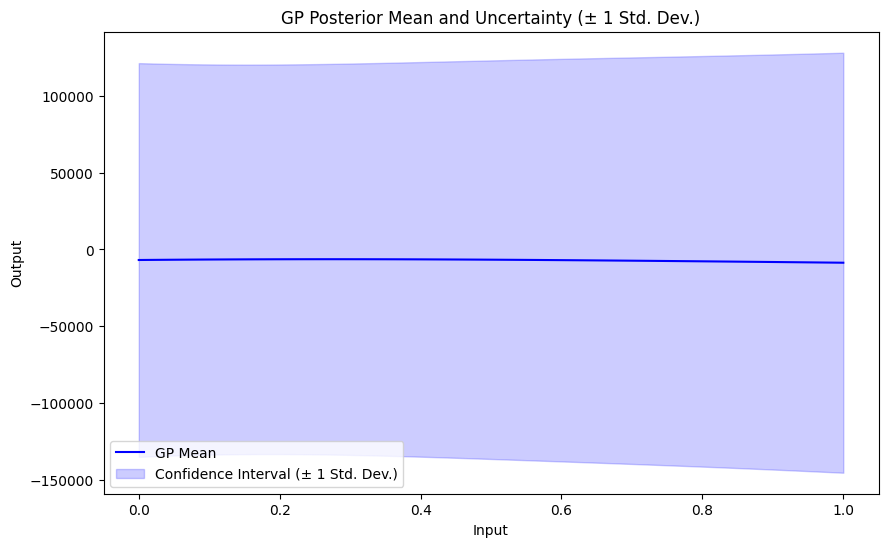

In [159]:
import matplotlib.pyplot as plt
gp.eval()

# Generate a range of input values for the first dimension (fixing other dimensions)
input_range = torch.linspace(0, 1, 100).unsqueeze(-1)  # Range of first dimension from 0 to 5

# print(input_range.shape)

# Create the corresponding input tensor by stacking the fixed second dimensions (e.g., fix them to 0)
input_tensor = torch.cat([input_range, 0.1*torch.ones_like(input_range), 0.2*torch.ones_like(input_range), 0.05*torch.ones_like(input_range), torch.ones_like(input_range), torch.ones_like(input_range), torch.ones_like(input_range)], dim=1)
# print(input_tensor.shape)
# Evaluate the posterior at the input points
posterior = gp.posterior(input_tensor)

# Extract the mean and variance
mean = posterior.mean.squeeze().detach()
variance = posterior.variance.squeeze().detach()
print(mean)
# Plot the GP mean and uncertainty (± variance)
plt.figure(figsize=(10, 6))
plt.plot(input_range.numpy(), mean.numpy(), label="GP Mean", color="blue")
plt.fill_between(input_range.squeeze().numpy(), 
                 (mean - torch.sqrt(variance)).numpy(), 
                 (mean + torch.sqrt(variance)).numpy(), 
                 color="blue", alpha=0.2, label="Confidence Interval (± 1 Std. Dev.)")

# # Optionally, plot the training points as well
# plt.scatter(train_x.numpy(), train_y.numpy(), color="red", label="Training Data", zorder=5)

plt.title("GP Posterior Mean and Uncertainty (± 1 Std. Dev.)")
plt.xlabel("Input")
plt.ylabel("Output")
plt.legend()
plt.show()

# Adding Constraints

In [ ]:
def constraint(design_variables_values):
    # target_wo 
    if (len(design_variables_values) != len(design_variables)):
        raise RuntimeError(f"design variable should be {len(design_variables)}, {len(design_variables_values)} given")
    sub_dict = {}
    for i, val in enumerate(design_variables_values, 0):
        sub_dict[design_variables[i]] = val


    constraint_func = wo_func**2 
    print(sub_dict)
    print((constraint_func.subs(sub_dict)))

    if (torch.tensor(float(constraint_func.subs(sub_dict))) > 0):
        return torch.tensor(float(constraint_func.subs(sub_dict))) - target_wo**2  # g(x) <= 0
    # invalid: negative physical quantity
    return 1


In [ ]:
# Example: Define multiple constraints
def constraint1(x):
    # Constraint 1: Sum of variables should not exceed 5
    return torch.sum(x, dim=-1) - 5.0  # g1(x) <= 0

def constraint2(x):
    # Constraint 2: Each variable must be non-negative
    return -x  # g2(x) <= 0 implies x >= 0


In [ ]:
def combined_constraints(x):
    penalties = []
    
    # Evaluate each constraint
    penalties.append(torch.clamp(constraint1(x), min=0.0) ** 2)
    penalties.append(torch.clamp(constraint2(x), min=0.0).sum(dim=-1) ** 2)
    
    # Sum up all penalties
    return sum(penalties)


# AX Platform

In [163]:
import logging
logging.basicConfig(level=logging.CRITICAL)


In [164]:
from ax import optimize

best_parameters, best_values, experiment, model = optimize(
        parameters=[
          {
            "name": "x1",
            "type": "range",
            "bounds": [-10.0, 10.0],
          },
          {
            "name": "x2",
            "type": "range",
            "bounds": [-10.0, 10.0],
          },
        ],
        # Booth function
        evaluation_function=lambda p: (p["x1"] + 2*p["x2"] - 7)**2 + (2*p["x1"] + p["x2"] - 5)**2,
        minimize=True,
    )

[INFO 01-18 20:15:13] ax.service.utils.instantiation: Inferred value type of ParameterType.FLOAT for parameter x1. If that is not the expected value type, you can explicitly specify 'value_type' ('int', 'float', 'bool' or 'str') in parameter dict.
[INFO 01-18 20:15:13] ax.service.utils.instantiation: Inferred value type of ParameterType.FLOAT for parameter x2. If that is not the expected value type, you can explicitly specify 'value_type' ('int', 'float', 'bool' or 'str') in parameter dict.
[INFO 01-18 20:15:13] ax.service.utils.instantiation: Created search space: SearchSpace(parameters=[RangeParameter(name='x1', parameter_type=FLOAT, range=[-10.0, 10.0]), RangeParameter(name='x2', parameter_type=FLOAT, range=[-10.0, 10.0])], parameter_constraints=[]).
[INFO 01-18 20:15:13] ax.modelbridge.dispatch_utils: Using Models.BOTORCH_MODULAR since there is at least one ordered parameter and there are no unordered categorical parameters.
[INFO 01-18 20:15:13] ax.modelbridge.dispatch_utils: Calc